In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import torch
from ogb.linkproppred import DglLinkPropPredDataset

Using backend: pytorch


In [4]:
dataset = DglLinkPropPredDataset('ogbl-ddi', root='data/dataset_dgl')
graph = dataset[0]

In [5]:
output_emb_file = 'deepwalk/models/01_deep_embedding.npy'

In [6]:
embeddings = np.load(output_emb_file)
embeddings.shape

(4267, 16)

## L2 Distance

In [7]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [8]:
index.train(embeddings)
index.add(embeddings)

In [9]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f8a7b58a210> >

In [10]:
index.ntotal

4267

### Check if the closest embedding is a neighbor

In [11]:
distances, indices = index.search(embeddings, 2)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(2265)

In [13]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [14]:
max_k = 200
distances, indices = index.search(embeddings, max_k + 1)

In [15]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [16]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

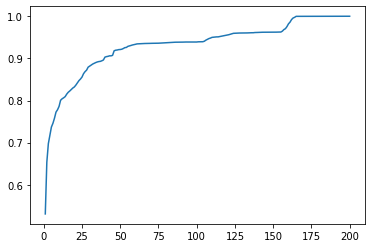

In [17]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

## Cossine Distance

In [18]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [19]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [20]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [21]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f8a78bfcf00> >

In [22]:
index_cos.ntotal

4267

### Check if the closest embedding is a neighbor

In [23]:
distances, indices = index_cos.search(emb_norm, 2)

In [24]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(2305)

In [25]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [26]:
max_k = 200
distances, indices = index.search(emb_norm, max_k + 1)

In [27]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [28]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

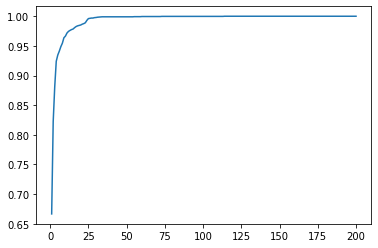

In [29]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)